In [2]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-darkgrid'])
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from theano.compile.ops import as_op
import theano.tensor as tt

/Users/Jenny/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
print('Running on PyMC3 v{}'.format(pm.__version__))
#inputting data
#data_base = np.loadtxt("Lyman_alpha_result_balout_z=3.2-3.3_testing.txt")
data_z = np.loadtxt("/Users/Jenny/Documents/pycodes/specdb/specdb/data/DB/Lyman_alpha_result_balout_z_ratio_mcmc_1075-1150_avecombine_highz_newbin_cut1075snr>2.2.txt")
data_all = np.loadtxt("/Users/Jenny/Documents/pycodes/specdb/specdb/data/DB/Lyman_alpha_result_balout_z>2.5_3.2base_1075-1150_mcmcflux_avecombine_highz_newbin_cut1075snr>2.2.txt")
data_error = np.loadtxt("/Users/Jenny/Documents/pycodes/specdb/specdb/data/DB/covariance_DR14/testalpha_1075-1150_error_0.5.txt")
data_z = data_z[:,0]
print (data_z)
i = range(0, len(data_all))
data_indi_flux = np.split(data_all[i,1], len(data_z))
data_indi_wave = np.split(data_all[i,0], len(data_z))
data_error_split = np.split(np.array(data_error), len(data_z))



#using schaye metal correction
data_indi_tau = [0.146,0.187,0.229,0.280,0.36]
data_redshift_base = [2.0,2.2,2.4,2.6,2.8]
data_error_base = [0.018,0.013,0.009,0.01,0.012]
data_indi_flux_final = np.append(data_indi_flux,np.array(data_indi_tau))
data_error_final=np.append(data_error_split,np.array(data_error_base))

Running on PyMC3 v3.4.1
[2.54882838 2.64806702 2.7478156  2.84952959 2.95062568 3.04919773
 3.14875346 3.2480309  3.3450856  3.4461385  3.5517966  3.64821476
 3.74814819 3.84554038 3.94690707 4.08444481 4.28969931 4.49270692
 4.69101035]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [conti11_interval__]
>Slice: [conti10_interval__]
>Slice: [conti9_interval__]
>Slice: [conti8_interval__]
>Slice: [conti7_interval__]
>Slice: [conti6_interval__]
>Slice: [conti5_interval__]
>Slice: [conti4_interval__]
>Slice: [conti3_interval__]
>Slice: [conti2_interval__]
>Slice: [conti1_interval__]
>Slice: [conti0_interval__]
>Slice: [index_interval__]
>Slice: [amp_interval__]
Could not pickle model, sampling singlethreaded.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [conti11_interval__]
>Slice: [conti10_interval__]
>Slice: [conti9_interval__]
>Slice: [conti8_interval__]
>Slice: [conti7_interval__]
>Slice: [conti6_interval__]
>Slice: [conti5_interval__]
>Slice: [conti4_interval__]
>Slice: [conti3_interval__]
>Slice: [conti2_interval__]
>Slice: [conti1_interva

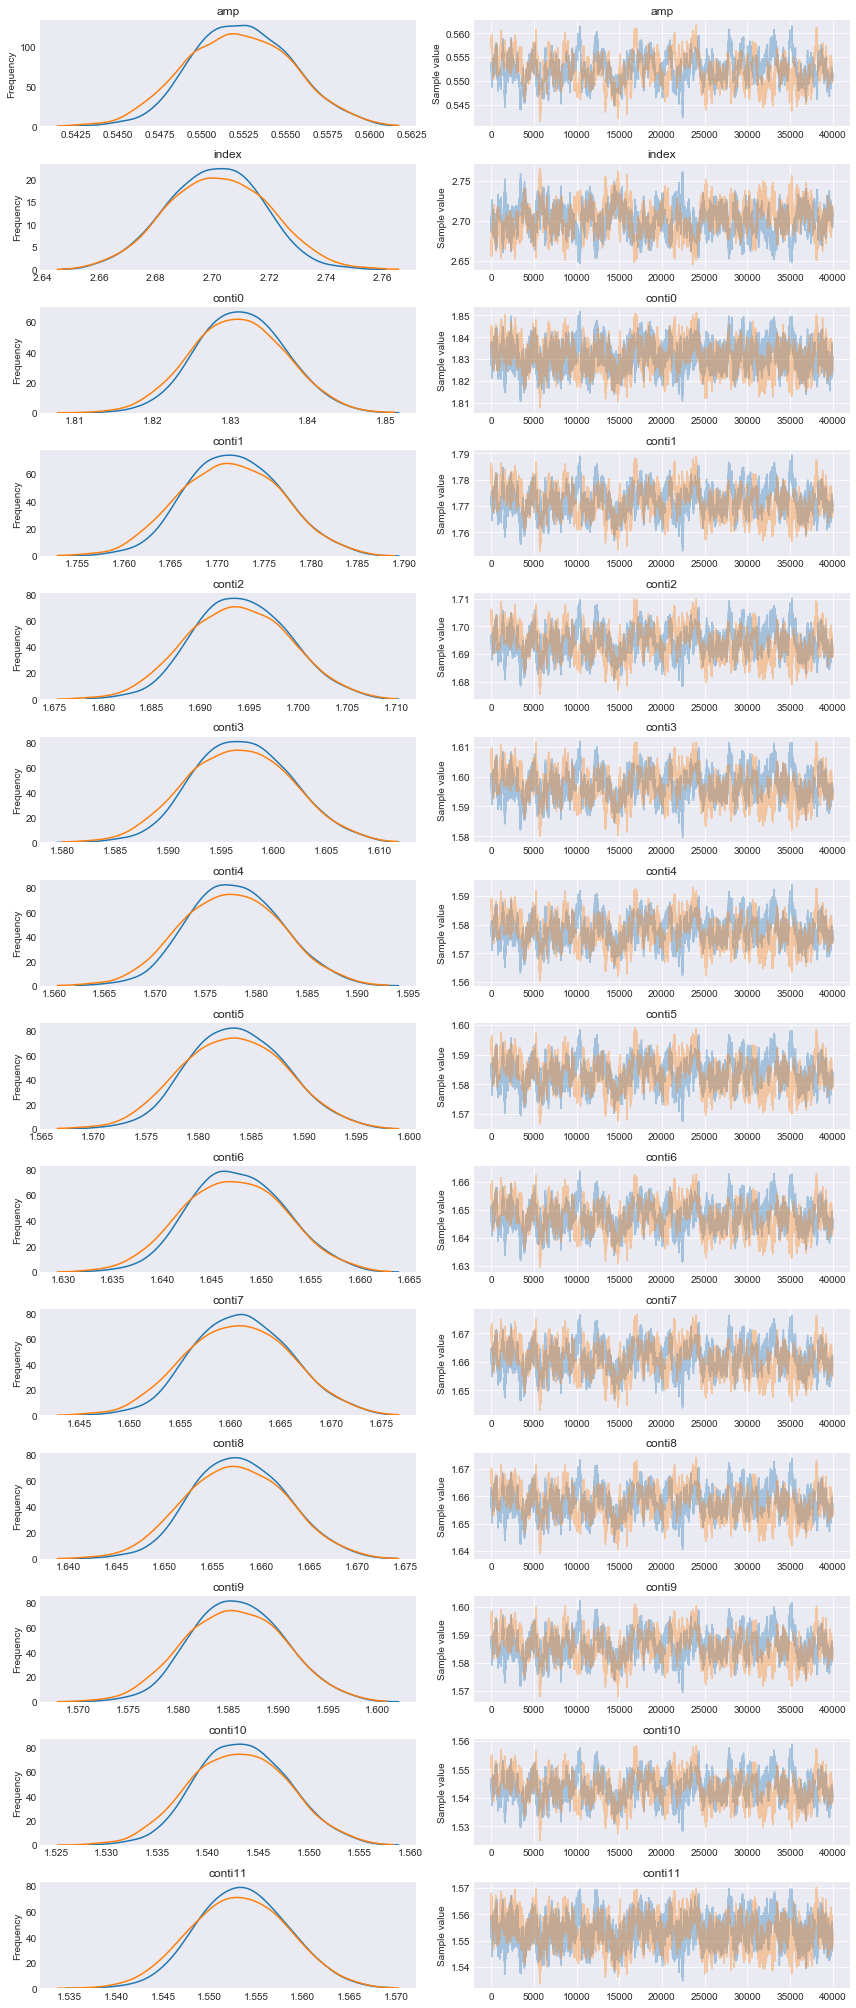

In [5]:
#checking verison of pymc3



n = 12



#assuming function of tau
def func(x,amp,index):
    func = amp * ((1 + x)/(1+3.05)) ** index
    return func





#x = data_indi_wave[5] / 1215.67 * (1 + data_z[5]) - 1
#fc1 = data_indi_flux[5] / np.exp(-func(x, 3, 5))



#setting up pymc3 model
@as_op(itypes=[tt.dscalar]*(n+2), otypes=[tt.dvector])
def fc(*para):
    

        
        #x = data_indi_wave[5] / 1215.67 * (1+data_z[5]) - 1
        #converting restframe wavelength to absorption redhsift
        x2 = np.array(data_indi_wave) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1

        
               
        
        
        #wavelength for continuum model
        xi = np.linspace(data_indi_wave[5][0], data_indi_wave[5][len(data_indi_wave[5])- 1], n)
        
        #defining the model with 12 parameters (2 for the tau and 10 for the spline points of the continuum)
        
        result_final = interp1d(xi, np.array(para[2:(n+2)]), kind='cubic')(data_indi_wave[5])*np.exp(-func(x2,para[0],para[1]))
        #result_final = result(data_indi_wave[5])*np.exp(-func(x2,amp,index))
        
        #adding the constraint from Faucher2008
        x1 = np.array(data_redshift_base)
        
        result_final1= np.append(result_final,func(x1, para[0], para[1]))
        

        return result_final1


if __name__ == '__main__':
    with pm.Model() as model:
        #the prior distribution of all the parameters
        para = []
        amp = pm.Uniform('amp',0.2,0.8)
        index = pm.Uniform('index', 1,5)
        n = 12
        para.append(amp)
        para.append(index)
        for i in range(0,n):
            para.append(pm.Uniform('conti'+str(i), 0.6, 2.3))
        #print (para)

        fc = fc(*para)
        #fit the model to observed data
        pymc_data = pm.Normal(str('output_data'), mu=fc, sd = np.array(data_error_final),observed=np.array(data_indi_flux_final))

        trace = pm.sample(40000,burn=7000,tune=3000)

pm.traceplot(trace)
plt.show()



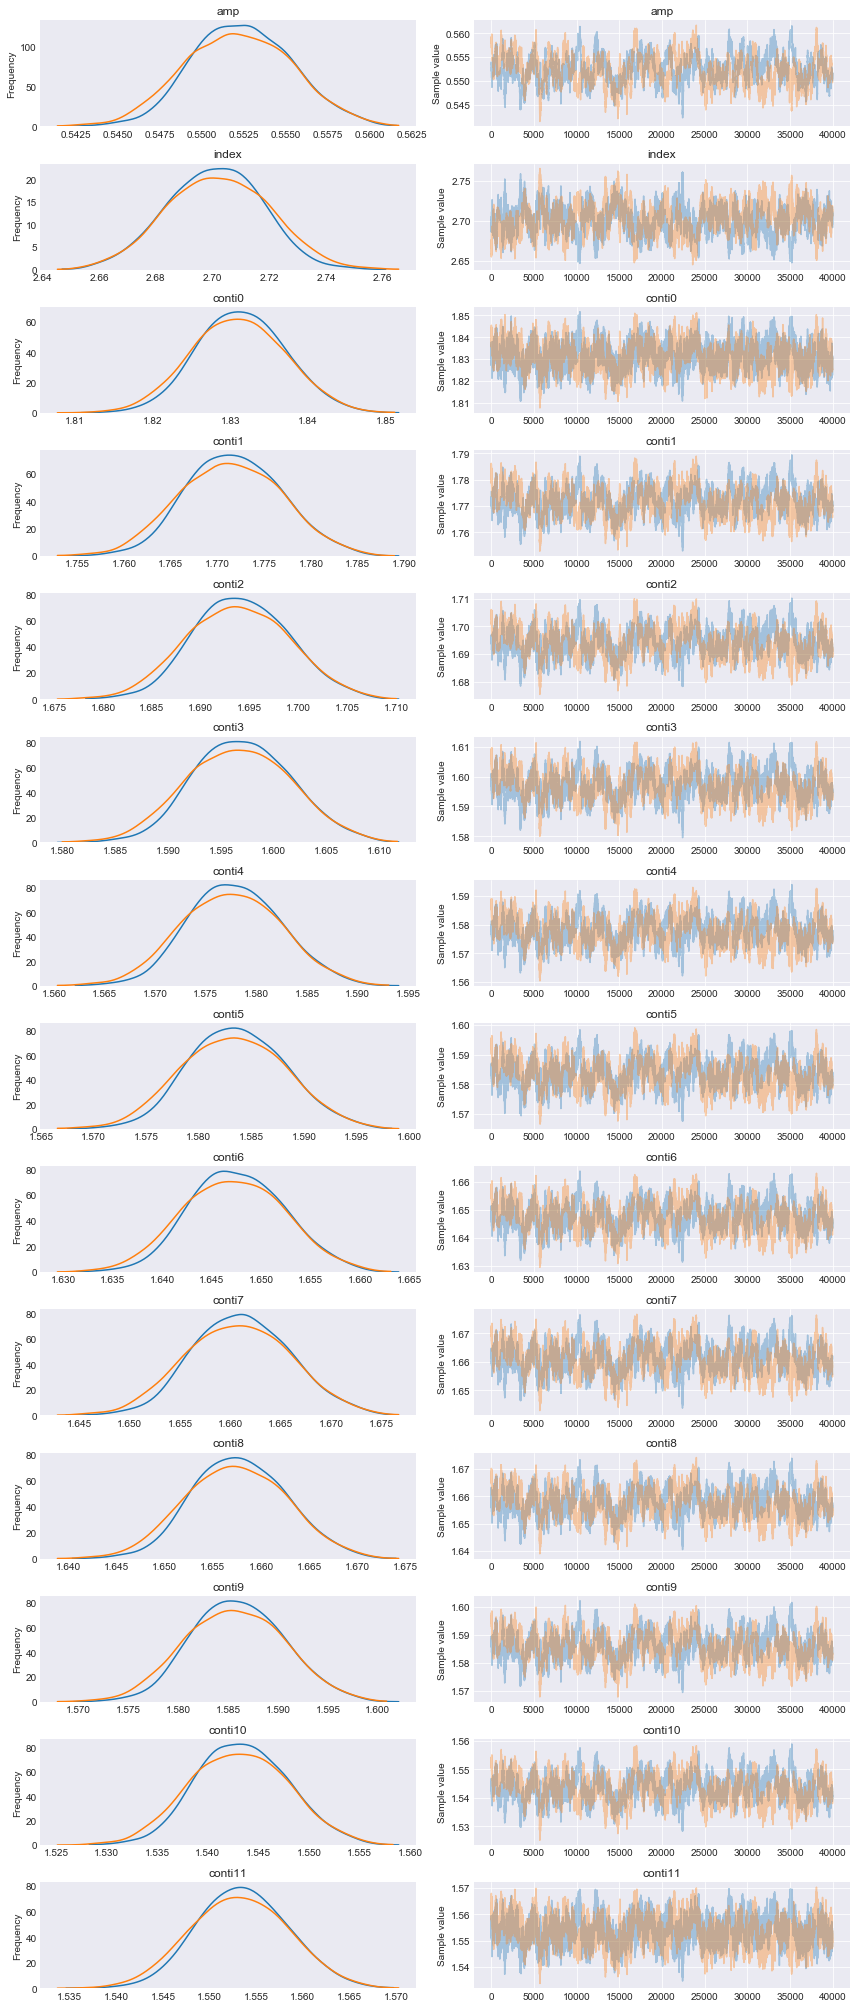

In [42]:
pm.traceplot(trace)
plt.savefig('trace_test.pdf')
plt.show()

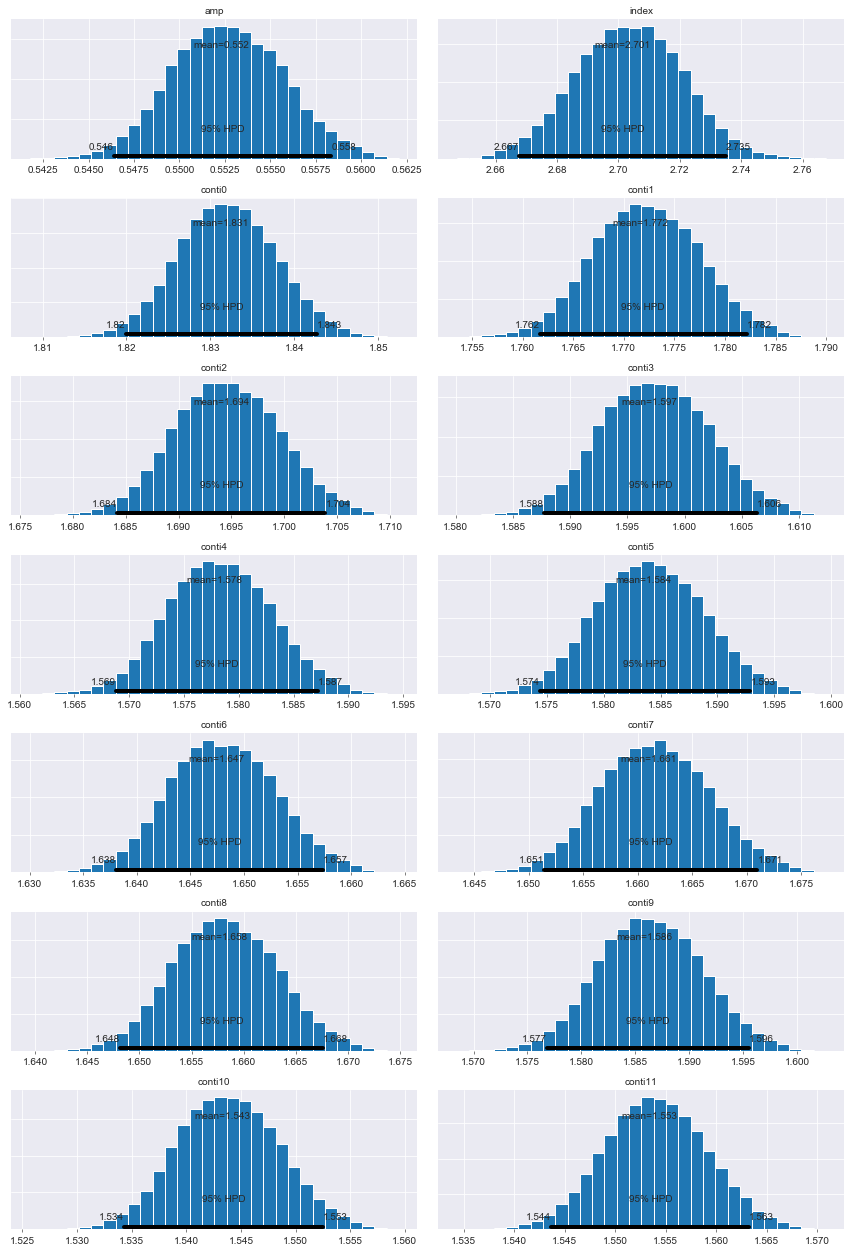

In [7]:
 #showing the distribution of different parameters
pm.plot_posterior(trace)
plt.show()

{'amp': 1.002028970949138, 'index': 1.002017480156755, 'conti0': 1.0018104243360795, 'conti1': 1.0019066857263557, 'conti2': 1.0018547752372198, 'conti3': 1.0019078544589208, 'conti4': 1.001983514399114, 'conti5': 1.0018481643002914, 'conti6': 1.002053218363949, 'conti7': 1.0019801873000884, 'conti8': 1.0020229597114745, 'conti9': 1.0019806595750607, 'conti10': 1.002023808003053, 'conti11': 1.001679241051728}


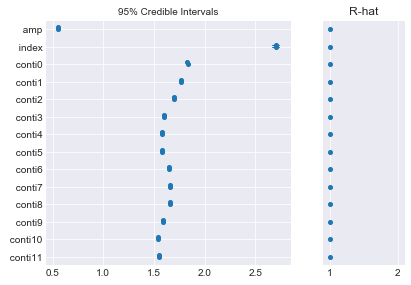

In [8]:
%matplotlib inline  
from pymc3 import forestplot
from pymc3 import gelman_rubin

print (gelman_rubin(trace))

forestplot(trace)

In [9]:
#parameter summary 
from pymc3 import summary

summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
amp,0.552325,0.003065,0.000205,0.546397,0.558353,154.305949,1.002029
index,2.701419,0.017363,0.001131,2.667464,2.735020,162.426265,1.002017
conti0,1.831230,0.005828,0.000358,1.819909,1.842665,182.259837,1.001810
conti1,1.771646,0.005259,0.000346,1.761678,1.782139,159.162781,1.001907
conti2,1.694019,0.005046,0.000332,1.684192,1.703888,158.955457,1.001855
conti3,1.596909,0.004777,0.000313,1.587739,1.606335,159.983836,1.001908
conti4,1.577731,0.004737,0.000310,1.568773,1.587260,160.738059,1.001984
conti5,1.583522,0.004757,0.000313,1.574411,1.592896,159.457373,1.001848
conti6,1.647425,0.004959,0.000325,1.638061,1.657395,160.429017,1.002053
conti7,1.660989,0.005005,0.000328,1.651448,1.670990,159.546726,1.001980


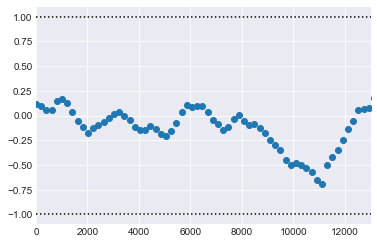

In [108]:
#convergence test
from pymc3 import geweke
    
z = geweke(trace, intervals=100)
#print (z[0])
plt.scatter(*z[0]['index'].T)
plt.hlines([-1,1], 0, 13000, linestyles='dotted')
plt.xlim(0, 13000)
plt.show()

In [38]:
#plotting the difference between mean model and the data
def plot_MCMC_model(n,xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    
    
    mean = []

    #for i in range(0,n+2):
         #mean.append(summary(trace)['mean'][i])
    trace_con = []       
    for i in range(0,n):
         trace_con.append(trace['conti'+str(i)])
        
        
    xi = np.linspace(xdata[5][0], xdata[5][len(xdata[5])- 1], n)
    x2 = np.array(xdata) / np.array(1215.67 / (1+np.array(np.split(data_z, len(data_z))))) - 1
  
    #print (continuum)
    result_model = []
    #result_final = interp1d(xi, np.array(mean[2:n+2]), kind='cubic')(xdata[5])*np.exp(-func(x2,mean[0],mean[1]))
    for i in range(0,  len(trace['amp'])):
    
        result_final=interp1d(xi, np.transpose(np.array(trace_con))[i], kind='cubic')(xdata[5])*np.exp(-func(x2,np.array(trace['amp'][i]),np.array(trace['index'][i])))
       
        x1 = np.array(data_redshift_base)
        #print (result_final)
        result_model.append(np.append(result_final,func(x1, trace['amp'][i],trace['index'][i])))
        

    
    resultfinal= np.mean(result_model,axis = 0)
    resultsdv = 3*np.std(result_model,axis = 0)
    print (resultsdv)
    
    fig, ax = plt.subplots(4, 2, figsize=(10, 8), gridspec_kw={'wspace': 0.08, 'hspace': 0.25}, sharex=False, sharey=False)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.9, top=0.9)
    fig.text(0.5, 0.001, 'Redshift', ha='center')
    fig.text(0.01, 0.5, 'Flux (arbitray units)', va='center', rotation='vertical')
    k = 10
    
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
            ax[index][jndex].plot(np.array(xdata[k]/1215.67*(1+data_z[k]))-1, ydata[k], c= 'k', label=str('{:.2f}'.format(data_z[k])) + ' data')
            ax[index][jndex].plot(np.array(xdata[k]/1215.67*(1+data_z[k]))-1, resultfinal[k*282:(k+1)*282], label='model')
            

            #ax[index][jndex].fill_between(np.array(xdata[k]/1215.67*(1+data_z[k]))-1, resultfinal[k*282:(k+1)*282] - resultsdv[k*282:(k+1)*282], resultfinal[k*282:(k+1)*282] + resultsdv[k*282:(k+1)*282],label='model stdev')
            
        # ax[index][jndex].axvline(rest_wave[i]*3.309,c='k',linestyle = '--',label = str(names[i]))
        # ax[index][jndex].axvline(rest_wave[i]*3.309,c='k',linestyle = '--')
        # ax[index][jndex].annotate('0.25 on axes', (0.25,4530), textcoords='data', size=20)
            ax[index][jndex].legend()
            #ax[index][jndex].set_xlabel('Redshift')
            #ax[index][jndex].set_ylabel('Flux')
        #ax[index][jndex].set_xticklabels('{:.2f}'.format(np.array(data_indi_wave[i]/1215.67*(1+data_z[i]))))
            
            
            k = k + 1
            
    plt.savefig('/Users/Jenny/desktop/modelondata_1.pdf')
    plt.show(fig)
    
   
    plt.plot(data_redshift_base,resultfinal[19*282:],label = 'mean model')
    #plt.fill_between(data_redshift_base, resultfinal[19*282:] - resultsdv[19*282:], resultfinal[19*282:] + resultsdv[19*282:],label='model stdev')
    plt.plot(data_redshift_base,data_indi_tau,label = 'data')
    plt.ylabel(r'$\rm{\tau{Ly\alpha}}$')
    plt.xlabel('redshift')
    plt.legend()
    plt.savefig('/Users/Jenny/desktop/modelondata_2.pdf')
    plt.show()
    
    
   # plt.fill_between(xdata, mu - sig, mu + sig, color='lightgray')
    
    

    return  result_model

In [ ]:
#calculating the chi square for individual data points
def chi_square(n,xdata, ydata, error, trace):
    chi_indi = []
    model_mean = plot_MCMC_model(n,xdata, ydata, trace)
   
    
    for i in range(0,len(ydata)):
        chi_indi.append(np.square(ydata[i]-model_mean[i*282:(i+1)*282])/np.square(error[i]))

    fig, ax = plt.subplots(9, 2, figsize=(13, 10), gridspec_kw={'wspace': 0.08, 'hspace': 0.25}, sharex=False, sharey=False)

    fig.subplots_adjust(left=0.05, bottom=0.05, right=1.2, top=0.9)
    k = 0
    
    
    
    
    print (len(xdata))
    degrees = [(0, 0), (1, 0), (2, 0), (3, 0), (0, 1), (1, 1), (2, 1), (0, 2), (1, 2), (0, 3)]
    for index in range(ax.shape[0]):
        for jndex in range(ax.shape[1]):
       
            #ax[index][jndex].plot(np.array(data_indi_wave[k]/1215.67*(1+data_z[k]))-1, data_indi_flux[k], label=str('{:.2f}'.format(data_z[k])) + ' data')
            ax[index][jndex].plot(np.array(xdata[k]/1215.67*(1+data_z[k]))-1, chi_indi[k], label='individual chi square for each data point')
        
                #ax[index][jndex].plot(np.array(constrainx[k]), chi_indi[k], label='individual chi square for each data point')
        # ax[index][jndex].axvline(rest_wave[i]*3.309,c='k',linestyle = '--',label = str(names[i]))
        # ax[index][jndex].axvline(rest_wave[i]*3.309,c='k',linestyle = '--')
        # ax[index][jndex].annotate('0.25 on axes', (0.25,4530), textcoords='data', size=20)
            ax[index][jndex].legend()
            ax[index][jndex].set_xlabel('redshift')
            ax[index][jndex].set_ylabel('')
        #ax[index][jndex].set_xticklabels('{:.2f}'.format(np.array(data_indi_wave[i]/1215.67*(1+data_z[i]))))

    
            k = k + 1
    plt.show(fig)
    plt.plot(data_redshift_base,np.square(data_indi_tau-model_mean[19*282:])/np.square(data_error_base))
    plt.xlabel('redshift')
    
    
    plt.show()
  
    
    

19


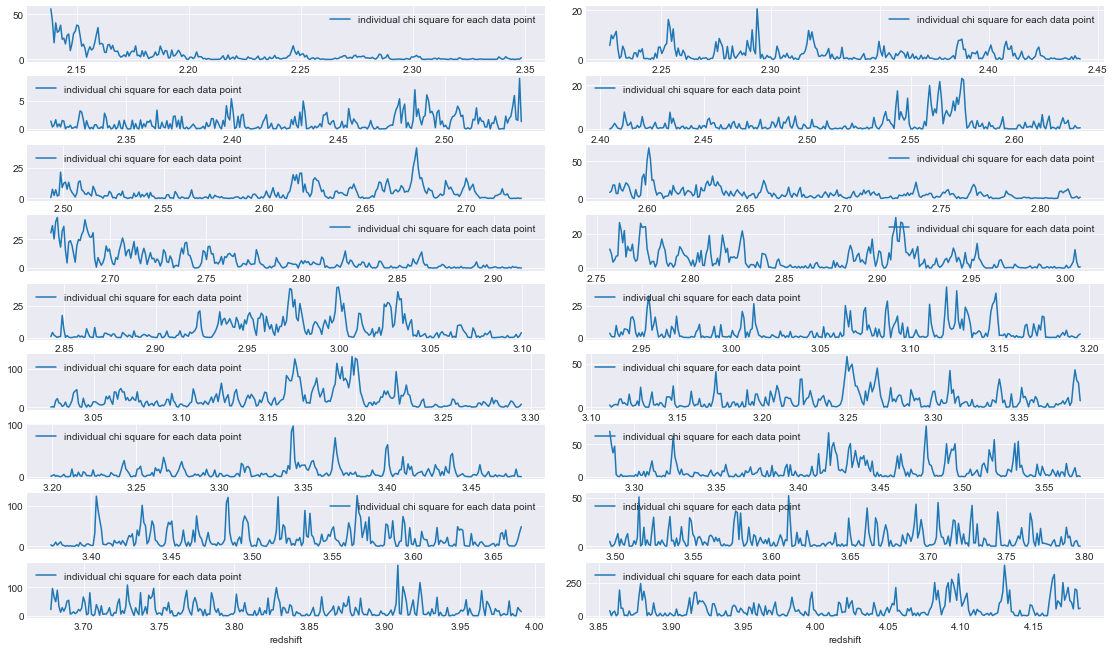

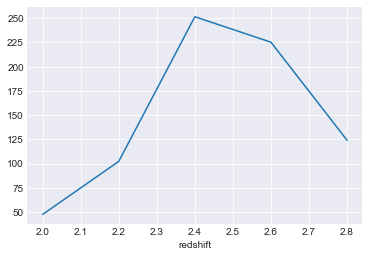

In [84]:
chi_square(12,data_indi_wave, data_indi_flux, data_error_final, trace)

In [59]:
def compute_sigma_level(trace1, trace2, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins, ybins = np.histogram2d(trace1, trace2, nbins)
    L[L == 0] = 1E-16

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]

    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])

    return xbins, ybins, L_cumsum[i_unsort].reshape(shape)


In [60]:
def plot_MCMC_trace(xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
    #_, ax = plt.subplots(1, 2, figsize=(10, 4))
    xbins, ybins, sigma = compute_sigma_level(trace['amp'], trace['index'])
    plt.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
    if scatter:
        ax.plot(trace['amp'], trace['index'], 'k', alpha=0.1)
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\beta$')
    

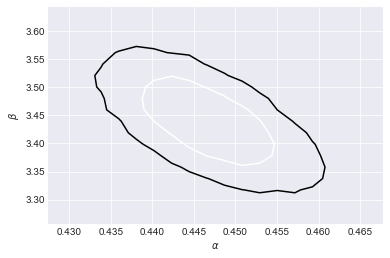

In [61]:
plot_MCMC_trace(data_indi_wave,data_indi_flux,trace)

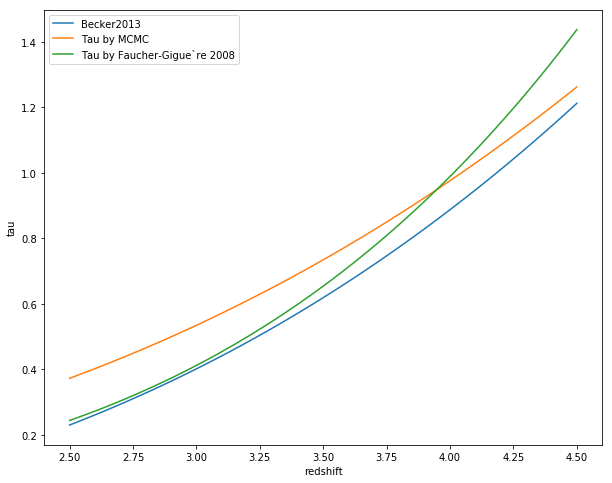

In [2]:
import numpy as np
from matplotlib import pylab as plt
plt.figure(figsize=(10,8))
xinput = np.linspace(2.5,4.5,100)
base_tau = 0.75124*((1+np.array(xinput))/(1+3.5))**2.9-0.132
base_tau3 = 0.0024*((1+np.array(xinput)))**3.824
base_tau2 =0.553*((1+np.array(xinput))/(1+3.05))**2.697
tau3 = 1.31704527e-03*((1+xinput))**4.03510671+4.03236979e-02
tau4 =  0.0018*(1+xinput)**3.92
plt.plot(xinput,base_tau,label = 'Becker2013')
plt.plot(xinput,base_tau2,label = 'Tau by MCMC')
#plt.plot(xinput,base_tau3,label = 'Tau by Suzuki')
plt.plot(xinput,tau4,label = 'Tau by Faucher-Gigue`re 2008')
plt.xlabel('redshift')
plt.ylabel('tau')

plt.legend()
plt.savefig('/Users/Jenny/desktop/result_plot.pdf')
plt.show()

In [12]:
import corner

In [26]:
def corner_plot(n,trace):
    cornerplot = []
    cornerplot.append(trace['amp'])
    cornerplot.append(trace['index'])
    names = []
    for i in range(0,n):
        cornerplot.append(trace['conti'+str(i)])
        names.append('conti'+str(i))
    
    figure = corner.corner(np.transpose(np.vstack(np.array(cornerplot))).reshape(len(trace['amp']),2+n),labels=["Amp", "Index",*names],show_titles=True, title_kwargs={"fontsize": 12},title_fmt = '.3f', quantiles = [0.32,0.5,0.68])
    plt.savefig('/Users/Jenny/desktop/corner_plot_2.pdf')
    plt.show()
    
   
    
    
    return cornerplot





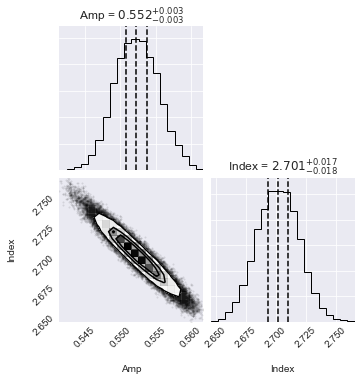

[array([0.55331471, 0.55372285, 0.55376162, ..., 0.55009141, 0.55004655,
        0.54960705]),
 array([2.68888438, 2.69429065, 2.69122308, ..., 2.71450715, 2.71075343,
        2.70570477])]

In [27]:
corner_plot(0,trace)